<a href="https://colab.research.google.com/github/danielececcarelli/DL_cardiac_segmentation/blob/main/acdc_data/train_acdc_with_google_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -U segmentation-models

     |████████████████████████████████| 51kB 6.2MB/s 


In [ ]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls "/content/drive/My Drive/"

 09022019-DSC_0016.jpg    RLbook2018.pdf
 09022019-DSC_0025.jpg    x_2d_test.npy
 09022019-DSC_0037.jpg    x_2d_train.npy
 09022019-DSC_0040.jpg    x_2d_val.npy
'Colab Notebooks'/        y_2d_test.npy
 foo.txt                  y_2d_train.npy
'PACS+Tesi Manzoni.zip'   y_2d_val.npy
 PACS.zip                'Zerocalcare - Kobane Calling.pdf'
 risultati50epochs/


In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import segmentation_models as sm
import numpy as np

path = "/content/drive/My Drive/"

x_train = np.load(path+"x_2d_train.npy")
y_train = np.load(path+"y_2d_train.npy")

x_val = np.load(path+"x_2d_val.npy")
y_val = np.load(path+"y_2d_val.npy")

x_test = np.load(path+"x_2d_test.npy")
y_test = np.load(path+"y_2d_test.npy")

Segmentation Models: using `tf.keras` framework.


In [ ]:
### standardization of train
for i in range(x_train.shape[0]):
    x_train[i,:,:,0] = x_train[i,:,:,0]/(np.max(x_train[i,:,:,0]))
    
### standardization of val
for i in range(x_val.shape[0]):
    x_val[i,:,:,0] = x_val[i,:,:,0]/(np.max(x_val[i,:,:,0]))
    
### standardization of test
for i in range(x_test.shape[0]):
    x_test[i,:,:,0] = x_test[i,:,:,0]/(np.max(x_test[i,:,:,0]))

In [ ]:
dim1,dim2,dim3,_ = y_train.shape
y_train_new = np.zeros(shape = (dim1,dim2,dim3,4))


for i in range(y_train.shape[0]):
    y_train_new[i,:,:,0] = (y_train[i,:,:,0]==1)
    y_train_new[i,:,:,1] = (y_train[i,:,:,0]==2)
    y_train_new[i,:,:,2] = (y_train[i,:,:,0]==3)
    y_train_new[i,:,:,3] = (y_train[i,:,:,0]==0)


dim1,dim2,dim3,_ = y_val.shape
y_val_new = np.zeros(shape = (dim1,dim2,dim3,4))


for i in range(y_val.shape[0]):
    y_val_new[i,:,:,0] = (y_val[i,:,:,0]==1)
    y_val_new[i,:,:,1] = (y_val[i,:,:,0]==2)
    y_val_new[i,:,:,2] = (y_val[i,:,:,0]==3)
    y_val_new[i,:,:,3] = (y_val[i,:,:,0]==0)



dim1,dim2,dim3,_ = y_test.shape
y_test_new = np.zeros(shape = (dim1,dim2,dim3,4))

for i in range(y_test.shape[0]):
    y_test_new[i,:,:,0] = (y_test[i,:,:,0]==1)
    y_test_new[i,:,:,1] = (y_test[i,:,:,0]==2)
    y_test_new[i,:,:,2] = (y_test[i,:,:,0]==3)
    y_test_new[i,:,:,3] = (y_test[i,:,:,0]==0)


y_train = y_train_new
y_val = y_val_new
y_test = y_test_new

In [ ]:
from segmentation_models.losses import dice_loss
from segmentation_models.metrics import iou_score

from keras.layers import Input, Conv2D
from keras.models import Model
from keras.optimizers import Adam

In [ ]:
bb = "vgg16"
input_shape = (256,256,3)
c = 4 ### multiclass classification
enc_weights = "imagenet"
activation = "softmax"
base_model = sm.Unet(backbone_name = bb, input_shape = input_shape, classes = c, activation=activation, encoder_weights = enc_weights)

# define number of channels
N = x_train.shape[-1] # = 1,
inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)

modelUnet = Model(inp, out, name=base_model.name)

lr = 0.0001
optim = Adam(lr)

dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 1, 1, 0.5])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

modelUnet.compile(optim, total_loss, metrics)

In [ ]:
path = "/content/drive/My Drive/"

ep = 100 #100

# fit model using Google COLAB to have access to GPU-computing!
history = modelUnet.fit(
    x=x_train,
    y=y_train,
    batch_size=8,
    epochs=ep,
    validation_data=(x_val, y_val))

name = path + "risultati100epochs/modelUnet_" + str(ep) + "epochs.keras"
modelUnet.save(name)

Epoch 1/100
150/150 [==============================] - 23s 156ms/step - loss: 0.9134 - iou_score: 0.2549 - f1-score: 0.3516 - val_loss: 0.8627 - val_iou_score: 0.3754 - val_f1-score: 0.5221
Epoch 2/100
150/150 [==============================] - 22s 149ms/step - loss: 0.7012 - iou_score: 0.5512 - f1-score: 0.6684 - val_loss: 0.7557 - val_iou_score: 0.5313 - val_f1-score: 0.6510
Epoch 3/100
150/150 [==============================] - 22s 150ms/step - loss: 0.5086 - iou_score: 0.6659 - f1-score: 0.7751 - val_loss: 0.5738 - val_iou_score: 0.6255 - val_f1-score: 0.7429
Epoch 4/100
150/150 [==============================] - 22s 150ms/step - loss: 0.3744 - iou_score: 0.7163 - f1-score: 0.8201 - val_loss: 0.4435 - val_iou_score: 0.6305 - val_f1-score: 0.7477
Epoch 5/100
150/150 [==============================] - 22s 150ms/step - loss: 0.3237 - iou_score: 0.7298 - f1-score: 0.8307 - val_loss: 0.3875 - val_iou_score: 0.6501 - val_f1-score: 0.7628
Epoch 6/100
150/150 [=============================

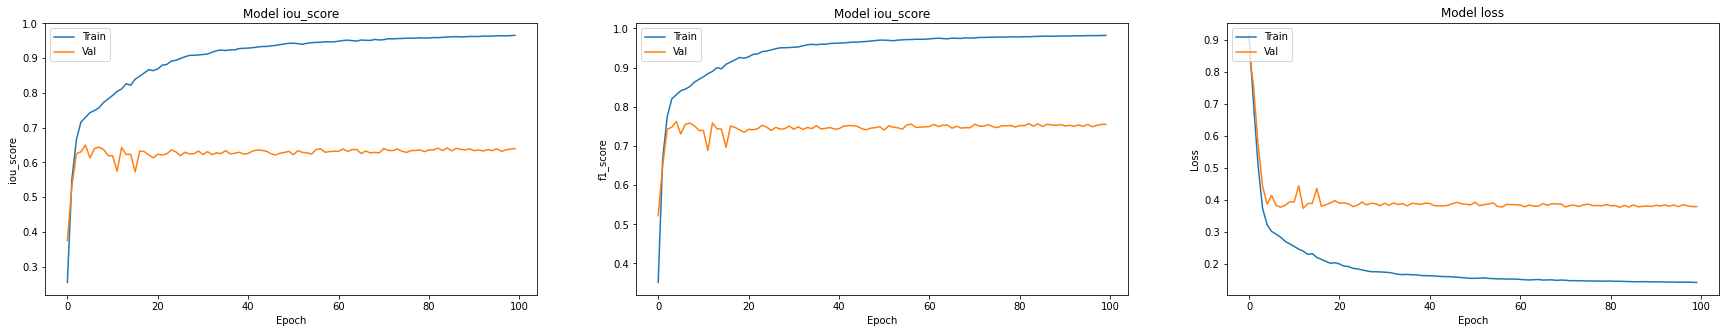

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(131)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation iou_score values
plt.subplot(132)
plt.plot(history.history["f1-score"])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1_score')
plt.ylabel('f1_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(133)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
#plt.show()
name = path + "risultati100epochs/loss_" + str(ep) + "epochs.png"
plt.savefig(name)

name =  str(ep) + "epochs.csv"
np.savetxt(path + "risultati100epochs/loss_" + name, history.history['loss'])
np.savetxt(path + "risultati100epochs/val_loss_" + name, history.history['val_loss'])
np.savetxt(path + "risultati100epochs/f1_" + name, history.history['f1-score'])
np.savetxt(path + "risultati100epochs/val_f1_" + name, history.history['val_f1-score'])
np.savetxt(path + "risultati100epochs/iou_" + name, history.history['iou_score'])
np.savetxt(path + "risultati100epochs/val_iou_" + name, history.history['val_iou_score'])
